For my portfolio project, I originally chose a dataset on water potability. It looked very interesting to me, because it consisted of several water quality measurements. After spending a lot of time and training several models (tuning hyperparameters using gridsearch and Bayesian Optimisation) and even performing PCA, I realised that there was something wrong, as I couldn't achieve an accuracy score of better than about 65 %. 

Disheartened, I had a look to see what others have acheived. This is when I discovered that the dataset is likely to be synthetic i.e. bogus. Other users' accuracy scores were very similar to mine. Some did score slightly higher (1-5%) than mine, but they did their pre-processing and standardisation before splitting. I split the dataset into train and test datasets before pre-processing, etc to avoid data-leakage. I learned a lot from my attempt on this bogus dataset. In particular, I learned that I need to be very wary of any publicly available datasets. The dataset did not specify its source or methods used to label the water as potable or not potable.

I then decided to search for an alternative dataset. This is when I stumbled upon the smoke detection dataset. The dataset looked appealing, because it uses data that is acquired from sensors that I have in the lab! It isn't as chellenging as the previous dataset, in that it doesn't have any missing values (NaNs); however, it does have more input features.

Rather than re-writing my code, I repurposed the code from my water potability model and tweaked it for the new dataset.

https://www.kaggle.com/code/dhavalrupapara/smoke-detection-using-machine-learning?select=smoke_detection_iot.csv

In [576]:
import numpy as np # linear algebra
import pandas as pd # data processing

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

I'll start by reading the csv file and creating a copy pandas dataframe

In [579]:
main_df = pd.read_csv("smoke_detection_iot.csv")
data_df = main_df.copy()
data_df_PCA = main_df.copy()

In [581]:
data_df

,UTC,Temperature,Humidity,TVOC,eCO2,Raw_H2,Raw_Ethanol,Pressure,PM1_0,PM2_5,NC0_5,NC1_0,NC2_5,CNT,Fire_Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


Let's do a bit of exploratory analysis. I should have done this on the water potability dataset! Would have saved me a lot of time.

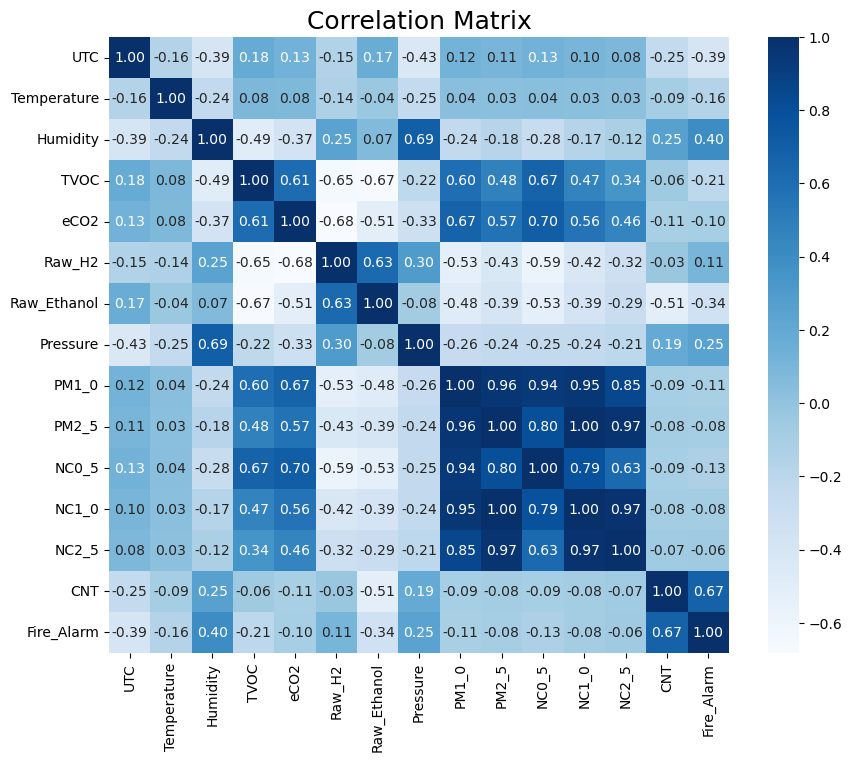

In [584]:
import seaborn as sns

f, ax = plt.subplots(figsize= [10,8])
sns.heatmap(data_df.corr(), annot=True, fmt=".2f", ax=ax, cmap = "Blues" )
ax.set_title("Correlation Matrix", fontsize=18)
plt.show()

Here, I see that CNT has a particularly strong positive correlation with Fire_alarm (0.67). Humidity also has a strong positive correlation with Fire_Alarm (0.40), while UTC has a strong negative correlation (-0.39), as does Raw_Ethanol (-0.34).

#### Create X and y dataframes

In [588]:
y_df = data_df.Fire_Alarm

In [594]:
#y_df

In [596]:
X_df = data_df.drop("Fire_Alarm", axis='columns')

#print(X_df)

In [598]:
# Quick check to see if there is any missing data...
X_df.isnull().sum()

UTC            0
Temperature    0
Humidity       0
TVOC           0
eCO2           0
Raw_H2         0
Raw_Ethanol    0
Pressure       0
PM1_0          0
PM2_5          0
NC0_5          0
NC1_0          0
NC2_5          0
CNT            0
dtype: int64

No missing data (NaNs), so I'll split the dataset before proceeding

#### Train test split before pre-processing to prevent data leakage

In [604]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=1234)

Check that my split has worked...

In [609]:
X_train

,UTC,Temperature,Humidity,TVOC,eCO2,Raw_H2,Raw_Ethanol,Pressure,PM1_0,PM2_5,NC0_5,NC1_0,NC2_5,CNT
56113,1654717158,50.820,25.00,60000,14137,11168,16392,936.850,5401.54,5644.10,37095.97,5835.645,162.090,4971
3176,1654736507,9.406,52.94,130,400,13231,20038,939.588,1.82,1.89,12.51,1.950,0.044,3176
18006,1654751337,18.294,50.11,1153,405,12912,19440,938.714,1.69,1.75,11.62,1.812,0.041,18006
10578,1654743909,1.817,55.48,862,645,12801,19520,939.094,2.38,2.48,16.40,2.557,0.058,10578
61416,1655128838,18.812,20.35,31536,698,12660,18759,936.897,0.42,0.44,2.91,0.454,0.010,4530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60620,1655128042,12.370,44.58,0,400,13407,21210,937.394,2.19,2.28,15.09,2.353,0.053,3734
56373,1654717418,57.200,12.87,60000,8033,11470,16845,936.732,726.10,890.61,4655.20,942.204,149.824,5231
34086,1654770435,18.280,58.05,380,400,13043,19884,939.267,0.53,0.56,3.68,0.574,0.013,9092
58067,1655125489,-8.799,41.13,79,400,12793,20657,937.484,1.91,1.99,13.16,2.052,0.046,1181


In [611]:
X_test

,UTC,Temperature,Humidity,TVOC,eCO2,Raw_H2,Raw_Ethanol,Pressure,PM1_0,PM2_5,NC0_5,NC1_0,NC2_5,CNT
27726,1654764075,20.840,46.29,101,400,13188,20090,939.638,0.98,1.02,6.75,1.053,0.024,2732
19778,1654753109,18.404,51.75,1220,413,12923,19417,938.712,1.66,1.72,11.42,1.780,0.040,19778
39327,1654775676,24.580,53.14,1145,483,12855,19447,938.905,2.02,2.10,13.91,2.169,0.049,14333
41147,1654777496,26.810,48.23,1164,407,12877,19443,938.784,1.61,1.67,11.08,1.728,0.039,16153
27566,1654763915,18.360,50.97,80,400,13195,20097,939.622,0.90,0.94,6.22,0.970,0.022,2572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17342,1654750673,15.509,53.09,1092,400,12908,19453,938.767,1.72,1.78,11.81,1.841,0.042,17342
31849,1654768198,21.090,50.26,208,400,13141,20041,939.602,0.41,0.43,2.83,0.442,0.010,6855
42187,1654778536,25.380,48.84,1222,417,12889,19430,938.771,1.46,1.52,10.06,1.570,0.035,17193
30923,1654767272,19.530,55.32,97,400,13212,20175,939.632,1.92,1.99,13.19,2.056,0.046,5929


In [417]:
# y_train

In [635]:
# y_test

Now that I've safely split the dataset into train and test sets, I can do some pre-processing.

#### Pre-process X_train and X_test

#### X_train

In [642]:
X_train

,UTC,Temperature,Humidity,TVOC,eCO2,Raw_H2,Raw_Ethanol,Pressure,PM1_0,PM2_5,NC0_5,NC1_0,NC2_5,CNT
0,0.011896,0.888821,0.221222,1.000000,0.230487,0.159490,0.176432,0.665779,0.376842,0.124231,0.603363,0.112408,5.398243e-03,0.198896
1,0.058201,0.383402,0.654670,0.002167,0.000000,0.817544,0.774824,0.969697,0.000127,0.000042,0.000203,0.000038,1.465375e-06,0.127076
2,0.093691,0.491872,0.610766,0.019217,0.000084,0.715789,0.676678,0.872683,0.000118,0.000039,0.000189,0.000035,1.365463e-06,0.720442
3,0.075915,0.290786,0.694074,0.014367,0.004111,0.680383,0.689808,0.914863,0.000166,0.000055,0.000267,0.000049,1.931631e-06,0.423239
4,0.997097,0.498194,0.149085,0.525600,0.005000,0.635407,0.564911,0.670996,0.000029,0.000010,0.000047,0.000009,3.330398e-07,0.181251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50099,0.995192,0.419575,0.524977,0.000000,0.000000,0.873684,0.967175,0.726163,0.000153,0.000050,0.000245,0.000045,1.765111e-06,0.149402
50100,0.012518,0.966683,0.033044,1.000000,0.128070,0.255821,0.250780,0.652681,0.050657,0.019603,0.075716,0.018149,4.989736e-03,0.209299
50101,0.139395,0.491701,0.733944,0.006333,0.000000,0.757576,0.749549,0.934066,0.000037,0.000012,0.000060,0.000011,4.329518e-07,0.363782
50102,0.989083,0.161228,0.471455,0.001317,0.000000,0.677831,0.876416,0.736153,0.000133,0.000044,0.000214,0.000040,1.531983e-06,0.047253


In [644]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)

In [646]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.011896,0.888821,0.221222,1.000000,0.230487,0.159490,0.176432,0.665779,0.376842,0.124231,0.603363,0.112408,5.398243e-03,0.198896
1,0.058201,0.383402,0.654670,0.002167,0.000000,0.817544,0.774824,0.969697,0.000127,0.000042,0.000203,0.000038,1.465375e-06,0.127076
2,0.093691,0.491872,0.610766,0.019217,0.000084,0.715789,0.676678,0.872683,0.000118,0.000039,0.000189,0.000035,1.365463e-06,0.720442
3,0.075915,0.290786,0.694074,0.014367,0.004111,0.680383,0.689808,0.914863,0.000166,0.000055,0.000267,0.000049,1.931631e-06,0.423239
4,0.997097,0.498194,0.149085,0.525600,0.005000,0.635407,0.564911,0.670996,0.000029,0.000010,0.000047,0.000009,3.330398e-07,0.181251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50099,0.995192,0.419575,0.524977,0.000000,0.000000,0.873684,0.967175,0.726163,0.000153,0.000050,0.000245,0.000045,1.765111e-06,0.149402
50100,0.012518,0.966683,0.033044,1.000000,0.128070,0.255821,0.250780,0.652681,0.050657,0.019603,0.075716,0.018149,4.989736e-03,0.209299
50101,0.139395,0.491701,0.733944,0.006333,0.000000,0.757576,0.749549,0.934066,0.000037,0.000012,0.000060,0.000011,4.329518e-07,0.363782
50102,0.989083,0.161228,0.471455,0.001317,0.000000,0.677831,0.876416,0.736153,0.000133,0.000044,0.000214,0.000040,1.531983e-06,0.047253


In [649]:
# Rename column name by index
X_train.rename(columns={X_train.columns[0]: 'UTC', X_train.columns[1]: 'Temperature', X_train.columns[2]: 'Humidity', 
                        X_train.columns[3]: 'TVOC', X_train.columns[4]: 'eCO2', X_train.columns[5]: 'Raw_H2', 
                        X_train.columns[6]: 'Raw_Ethanol', X_train.columns[7]: 'Pressure', X_train.columns[8]: 'PM1_0', 
                        X_train.columns[9]: 'PM2_5', X_train.columns[10]: 'NC0_5', X_train.columns[11]: 'NC1_0', 
                        X_train.columns[12]: 'NC2_5', X_train.columns[13]: 'CNT'},inplace=True)

In [651]:
X_train

,UTC,Temperature,Humidity,TVOC,eCO2,Raw_H2,Raw_Ethanol,Pressure,PM1_0,PM2_5,NC0_5,NC1_0,NC2_5,CNT
0,0.011896,0.888821,0.221222,1.000000,0.230487,0.159490,0.176432,0.665779,0.376842,0.124231,0.603363,0.112408,5.398243e-03,0.198896
1,0.058201,0.383402,0.654670,0.002167,0.000000,0.817544,0.774824,0.969697,0.000127,0.000042,0.000203,0.000038,1.465375e-06,0.127076
2,0.093691,0.491872,0.610766,0.019217,0.000084,0.715789,0.676678,0.872683,0.000118,0.000039,0.000189,0.000035,1.365463e-06,0.720442
3,0.075915,0.290786,0.694074,0.014367,0.004111,0.680383,0.689808,0.914863,0.000166,0.000055,0.000267,0.000049,1.931631e-06,0.423239
4,0.997097,0.498194,0.149085,0.525600,0.005000,0.635407,0.564911,0.670996,0.000029,0.000010,0.000047,0.000009,3.330398e-07,0.181251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50099,0.995192,0.419575,0.524977,0.000000,0.000000,0.873684,0.967175,0.726163,0.000153,0.000050,0.000245,0.000045,1.765111e-06,0.149402
50100,0.012518,0.966683,0.033044,1.000000,0.128070,0.255821,0.250780,0.652681,0.050657,0.019603,0.075716,0.018149,4.989736e-03,0.209299
50101,0.139395,0.491701,0.733944,0.006333,0.000000,0.757576,0.749549,0.934066,0.000037,0.000012,0.000060,0.000011,4.329518e-07,0.363782
50102,0.989083,0.161228,0.471455,0.001317,0.000000,0.677831,0.876416,0.736153,0.000133,0.000044,0.000214,0.000040,1.531983e-06,0.047253


In [653]:
y_train

56113    0
3176     0
18006    1
10578    1
61416    0
        ..
60620    0
56373    0
34086    1
58067    0
27439    0
Name: Fire_Alarm, Length: 50104, dtype: int64

In [655]:
y_train.to_frame()

,Fire_Alarm
56113,0
3176,0
18006,1
10578,1
61416,0
...,...
60620,0
56373,0
34086,1
58067,0


In [666]:
y_train = y_train.reset_index()

In [668]:
y_train

,index,Fire_Alarm
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0
...,...,...
50099,50099,0
50100,50100,0
50101,50101,1
50102,50102,0


In [670]:
y_train = y_train.drop("index", axis='columns')

In [672]:
y_train

,Fire_Alarm
0,0
1,0
2,1
3,1
4,0
...,...
50099,0
50100,0
50101,1
50102,0


Do the same for the test dataset.

#### X_test

In [686]:
X_test

,UTC,Temperature,Humidity,TVOC,eCO2,Raw_H2,Raw_Ethanol,Pressure,PM1_0,PM2_5,NC0_5,NC1_0,NC2_5,CNT
0,0.124173,0.524095,0.551505,0.001683,0.000000,0.804807,0.780220,0.975775,0.000069,0.000023,0.000110,0.000021,8.122575e-07,0.109311
1,0.097930,0.494300,0.636209,0.020333,0.000218,0.718740,0.668165,0.872875,0.000117,0.000038,0.000186,0.000035,1.353762e-06,0.791342
2,0.151936,0.569839,0.657772,0.019083,0.001393,0.696655,0.673160,0.894322,0.000143,0.000047,0.000226,0.000042,1.658359e-06,0.573481
3,0.156292,0.597114,0.581601,0.019400,0.000117,0.703800,0.672494,0.880876,0.000114,0.000037,0.000180,0.000034,1.319918e-06,0.646301
4,0.123790,0.493762,0.624108,0.001333,0.000000,0.807080,0.781385,0.973997,0.000064,0.000021,0.000101,0.000019,7.445694e-07,0.102909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12521,0.092100,0.458892,0.656997,0.018200,0.000000,0.713868,0.674159,0.878987,0.000122,0.000040,0.000192,0.000036,1.421451e-06,0.693874
12522,0.134040,0.527153,0.613093,0.003467,0.000000,0.789542,0.772061,0.971775,0.000029,0.000010,0.000046,0.000009,3.384406e-07,0.274277
12523,0.158780,0.579623,0.591064,0.020367,0.000285,0.707697,0.670330,0.879431,0.000103,0.000034,0.000164,0.000031,1.184542e-06,0.687913
12524,0.131824,0.508072,0.691592,0.001617,0.000000,0.812601,0.794372,0.975108,0.000136,0.000044,0.000215,0.000040,1.556827e-06,0.237226


In [688]:
X_test = min_max_scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [690]:
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.124173,0.524095,0.551505,0.001683,0.000000,0.804807,0.780220,0.975775,0.000069,0.000023,0.000110,0.000021,8.122575e-07,0.109311
1,0.097930,0.494300,0.636209,0.020333,0.000218,0.718740,0.668165,0.872875,0.000117,0.000038,0.000186,0.000035,1.353762e-06,0.791342
2,0.151936,0.569839,0.657772,0.019083,0.001393,0.696655,0.673160,0.894322,0.000143,0.000047,0.000226,0.000042,1.658359e-06,0.573481
3,0.156292,0.597114,0.581601,0.019400,0.000117,0.703800,0.672494,0.880876,0.000114,0.000037,0.000180,0.000034,1.319918e-06,0.646301
4,0.123790,0.493762,0.624108,0.001333,0.000000,0.807080,0.781385,0.973997,0.000064,0.000021,0.000101,0.000019,7.445694e-07,0.102909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12521,0.092100,0.458892,0.656997,0.018200,0.000000,0.713868,0.674159,0.878987,0.000122,0.000040,0.000192,0.000036,1.421451e-06,0.693874
12522,0.134040,0.527153,0.613093,0.003467,0.000000,0.789542,0.772061,0.971775,0.000029,0.000010,0.000046,0.000009,3.384406e-07,0.274277
12523,0.158780,0.579623,0.591064,0.020367,0.000285,0.707697,0.670330,0.879431,0.000103,0.000034,0.000164,0.000031,1.184542e-06,0.687913
12524,0.131824,0.508072,0.691592,0.001617,0.000000,0.812601,0.794372,0.975108,0.000136,0.000044,0.000215,0.000040,1.556827e-06,0.237226


In [692]:
# Rename column name by index
X_test.rename(columns={X_test.columns[0]: 'UTC', X_test.columns[1]: 'Temperature', X_test.columns[2]: 'Humidity', 
                        X_test.columns[3]: 'TVOC', X_test.columns[4]: 'eCO2', X_test.columns[5]: 'Raw_H2', 
                        X_test.columns[6]: 'Raw_Ethanol', X_test.columns[7]: 'Pressure', X_test.columns[8]: 'PM1_0', 
                        X_test.columns[9]: 'PM2_5', X_test.columns[10]: 'NC0_5', X_test.columns[11]: 'NC1_0', 
                        X_test.columns[12]: 'NC2_5', X_test.columns[13]: 'CNT'},inplace=True)

In [694]:
X_test

,UTC,Temperature,Humidity,TVOC,eCO2,Raw_H2,Raw_Ethanol,Pressure,PM1_0,PM2_5,NC0_5,NC1_0,NC2_5,CNT
0,0.124173,0.524095,0.551505,0.001683,0.000000,0.804807,0.780220,0.975775,0.000069,0.000023,0.000110,0.000021,8.122575e-07,0.109311
1,0.097930,0.494300,0.636209,0.020333,0.000218,0.718740,0.668165,0.872875,0.000117,0.000038,0.000186,0.000035,1.353762e-06,0.791342
2,0.151936,0.569839,0.657772,0.019083,0.001393,0.696655,0.673160,0.894322,0.000143,0.000047,0.000226,0.000042,1.658359e-06,0.573481
3,0.156292,0.597114,0.581601,0.019400,0.000117,0.703800,0.672494,0.880876,0.000114,0.000037,0.000180,0.000034,1.319918e-06,0.646301
4,0.123790,0.493762,0.624108,0.001333,0.000000,0.807080,0.781385,0.973997,0.000064,0.000021,0.000101,0.000019,7.445694e-07,0.102909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12521,0.092100,0.458892,0.656997,0.018200,0.000000,0.713868,0.674159,0.878987,0.000122,0.000040,0.000192,0.000036,1.421451e-06,0.693874
12522,0.134040,0.527153,0.613093,0.003467,0.000000,0.789542,0.772061,0.971775,0.000029,0.000010,0.000046,0.000009,3.384406e-07,0.274277
12523,0.158780,0.579623,0.591064,0.020367,0.000285,0.707697,0.670330,0.879431,0.000103,0.000034,0.000164,0.000031,1.184542e-06,0.687913
12524,0.131824,0.508072,0.691592,0.001617,0.000000,0.812601,0.794372,0.975108,0.000136,0.000044,0.000215,0.000040,1.556827e-06,0.237226


In [696]:
y_test

27726    0
19778    1
39327    1
41147    1
27566    0
        ..
17342    1
31849    1
42187    1
30923    1
36627    1
Name: Fire_Alarm, Length: 12526, dtype: int64

In [698]:
y_test.to_frame()

,Fire_Alarm
27726,0
19778,1
39327,1
41147,1
27566,0
...,...
17342,1
31849,1
42187,1
30923,1


In [700]:
y_test = y_test.reset_index()

In [702]:
y_test

,index,Fire_Alarm
0,27726,0
1,19778,1
2,39327,1
3,41147,1
4,27566,0
...,...,...
12521,17342,1
12522,31849,1
12523,42187,1
12524,30923,1


In [704]:
y_test = y_test.drop("index", axis='columns')

In [706]:
y_test

,Fire_Alarm
0,0
1,1
2,1
3,1
4,0
...,...
12521,1
12522,1
12523,1
12524,1


#### Visualise data

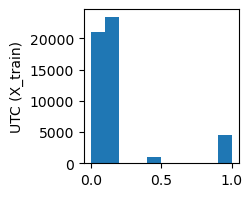

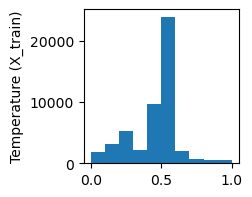

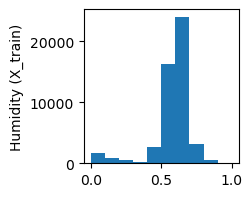

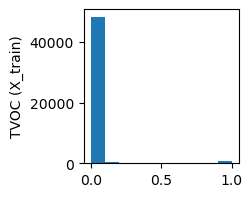

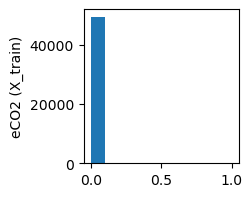

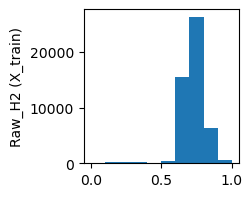

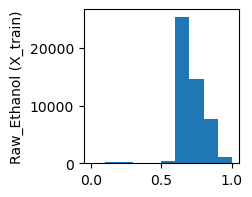

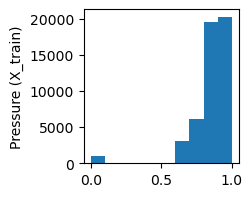

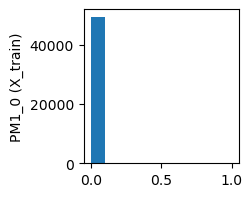

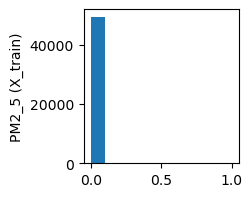

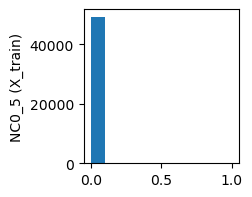

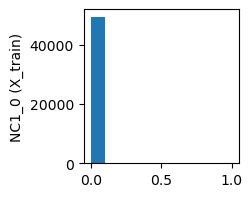

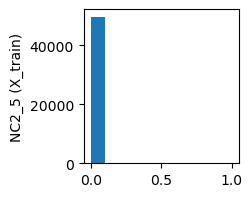

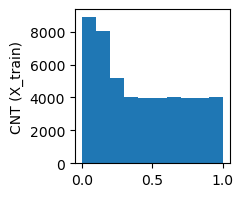

In [709]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))
plt.ylabel("UTC (X_train)")
plt.hist(X_train.UTC)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("Temperature (X_train)")
plt.hist(X_train.Temperature)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("Humidity (X_train)")
plt.hist(X_train.Humidity)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("TVOC (X_train)")
plt.hist(X_train.TVOC)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("eCO2 (X_train)")
plt.hist(X_train.eCO2)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("Raw_H2 (X_train)")
plt.hist(X_train.Raw_H2)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("Raw_Ethanol (X_train)")
plt.hist(X_train.Raw_Ethanol)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("Pressure (X_train)")
plt.hist(X_train.Pressure)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("PM1_0 (X_train)")
plt.hist(X_train.PM1_0)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("PM2_5 (X_train)")
plt.hist(X_train.PM2_5)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("NC0_5 (X_train)")
plt.hist(X_train.NC0_5)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("NC1_0 (X_train)")
plt.hist(X_train.NC1_0)
plt.show()

#############
plt.figure(figsize=(2,2))
plt.ylabel("NC2_5 (X_train)")
plt.hist(X_train.NC2_5)
plt.show()

plt.figure(figsize=(2,2))
plt.ylabel("CNT (X_train)")
plt.hist(X_train.CNT)
plt.show()

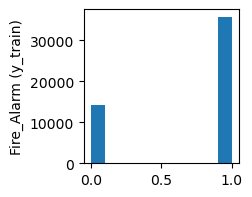

In [712]:
plt.figure(figsize=(2,2))
plt.ylabel("Fire_Alarm (y_train)")
plt.hist(y_train)
plt.show()

Note: A bit of an imbalance in the predictor values

In [715]:
print('Training data shape:', X_train.shape, y_train.shape)
print('Testing data shape:', X_test.shape, y_test.shape)

Training data shape: (50104, 14) (50104, 1)
Testing data shape: (12526, 14) (12526, 1)


In [717]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


I'm now going to try training some models to see what accuracies I get with the default settings.

# MODEL TRAINING

### Logistic Regression

In [807]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [809]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.9692639310234712
Recall: 0.9696562534990483
Precision: 0.9870070663323456


Straight away, I see that I can get excellent accuracy, recall and precision with Logistic Regression using the default hyperparameter settings.

I'll plot a confusion matrix to get a visual representation of my results with the test dataset.

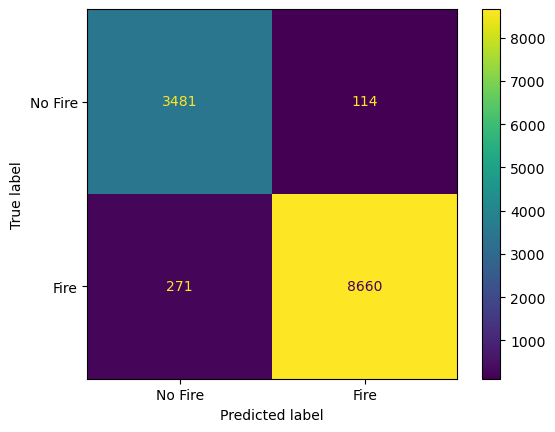

In [812]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Fire', 'Fire'])
cm_display.plot()
plt.show()

I want to see if I can improve the prediction accuracy by tuning the model's hyperparameters. I will do this using gridsearch, because there are only 3 hyperparameters to tune and the search space isn't very large

In [815]:
from sklearn.model_selection import RepeatedStratifiedKFold

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]


logreg = LogisticRegression(random_state=16)

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Best: 0.991584 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.9692639310234712
Recall: 0.9696562534990483
Precision: 0.9870070663323456


In [818]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(C=100, penalty='l2', solver='liblinear', random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.991218266006706
Recall: 0.994961370507222
Precision: 0.9927382415372584


### Descision Tree Classifier

In [773]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=16)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [775]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.9999201660546064
Recall: 1.0
Precision: 0.9998880429914913


Straight away, I see that I can get excellent accuracy, recall and precision with a Decision Tree classifier using the default hyperparameter settings.

I'll plot the confusion matrix to give a visual representation of my results.

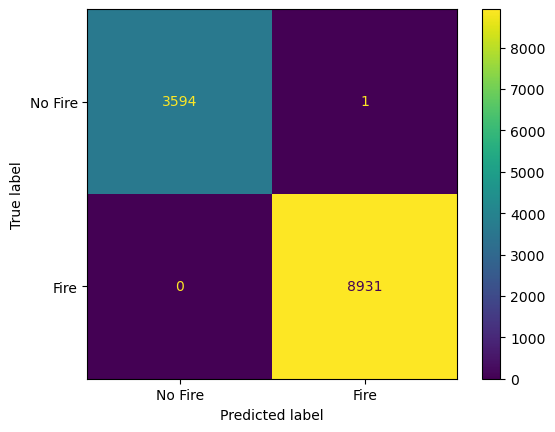

In [779]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Fire', 'Fire'])
cm_display.plot()
plt.show()

Let's look at the tree plot...

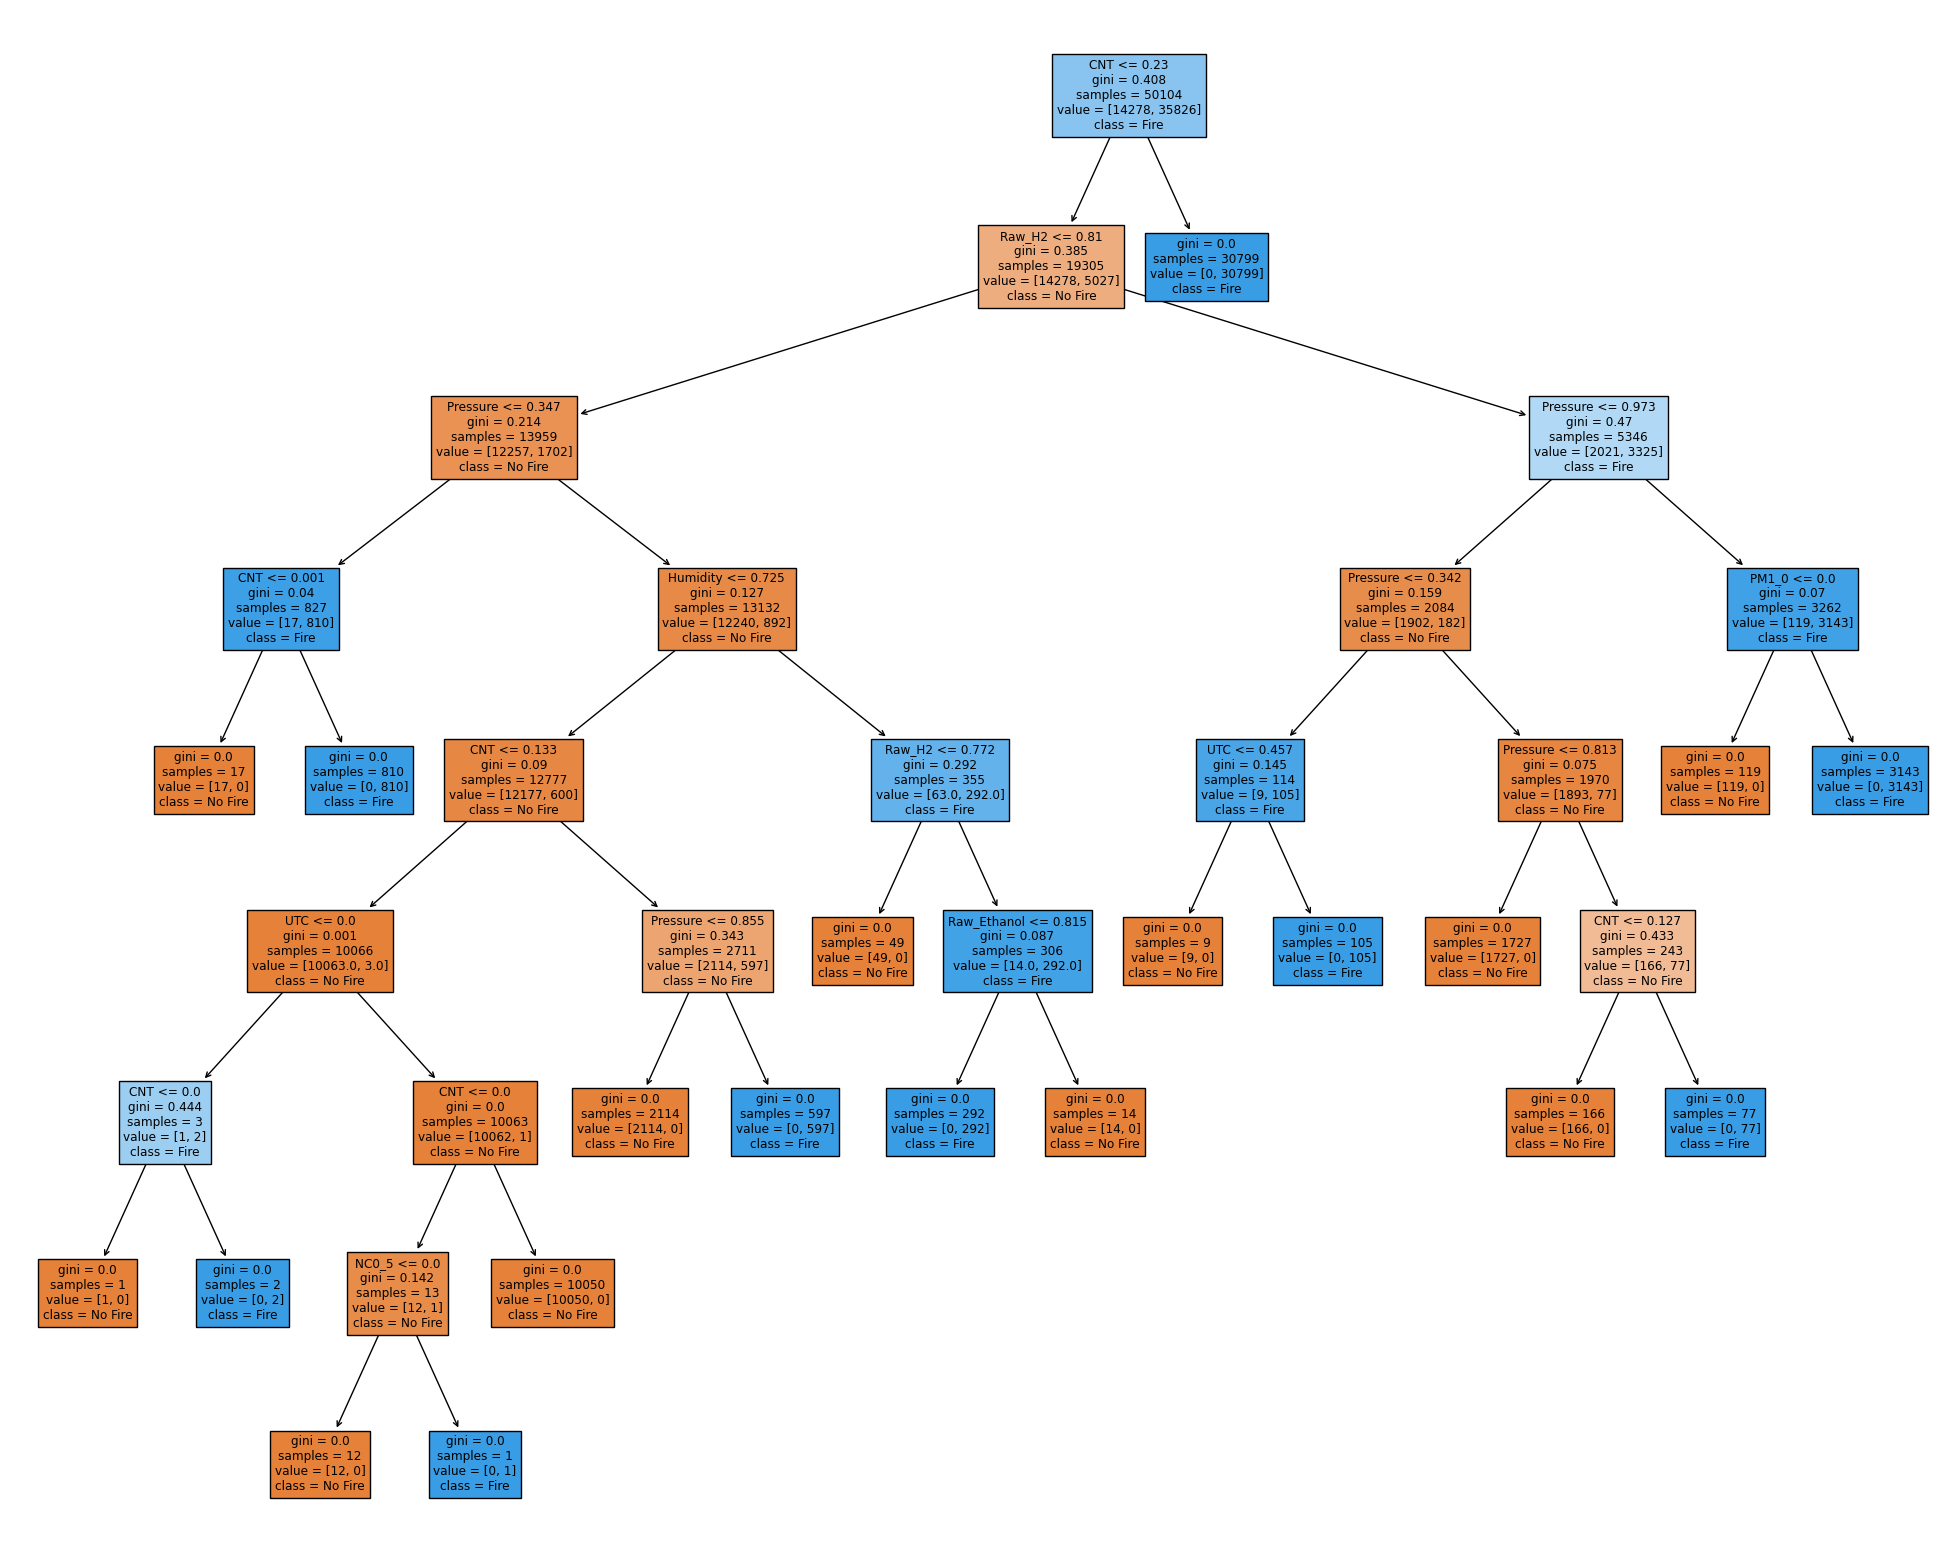

In [782]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names=X_test.columns,
                   class_names=['No Fire', "Fire"],
                   filled=True)

I wonder if I can improve the prediction accuracy? Let's try tuning the Decision Tree's hyperparameters. I'll use grid search for now, as I only have 3 hyperparameters to tune and the search space isn't very large.

### Random Forest Classifier

In [784]:
from sklearn.ensemble import RandomForestClassifier

# Create Decision Tree classifer object
clf = RandomForestClassifier(random_state=16)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [785]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.9998403321092129
Recall: 0.9997760609114321
Precision: 1.0


Almost perfect!

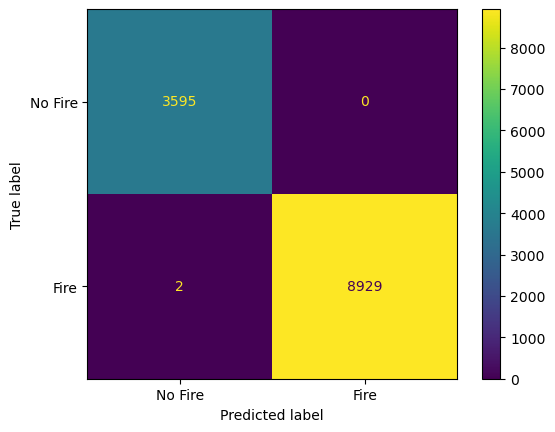

In [789]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Fire', 'Fire'])
cm_display.plot()
plt.show()

### Support Vector Machine classifier

In [792]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
#svmc = svm.SVC(kernel='linear') # Linear Kernel
svmc = svm.SVC(kernel='rbf') 
#svmc = svm.SVC(kernel="poly", degree=3) 

#Train the model using the training sets
svmc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svmc.predict(X_test)

In [794]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.9993613284368513
Recall: 0.9998880304557161
Precision: 0.9992167393980083


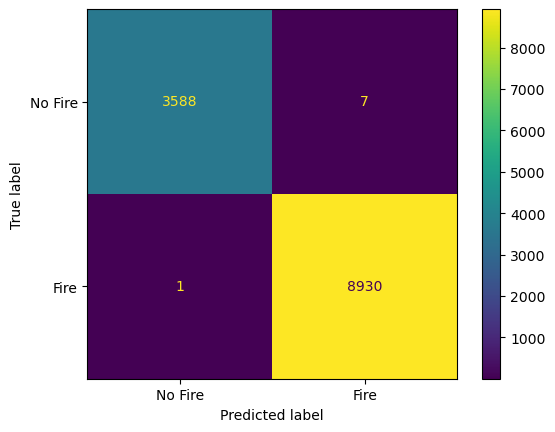

In [796]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Fire', 'Fire'])
cm_display.plot()
plt.show()

### Gradient Boosting

In [800]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=16)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

In [801]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.9999201660546064
Recall: 0.9998880304557161
Precision: 1.0


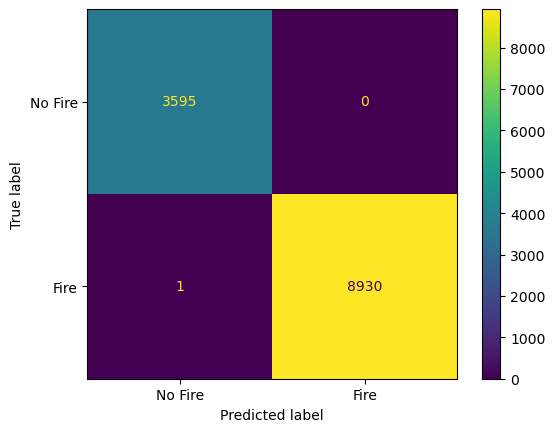

In [802]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Fire', 'Fire'])
cm_display.plot()
plt.show()

# DISCUSSION

The dataset used in to train these models was provided by a DIY Arduino hacker, and was developed for his personal fire alarm project. I was drawn to it, because it closely matches some of my industry problems, since it incorporates electronic sensor data. The dataset is very simple and does not represent a wide range of fire scenarios. It should therefore only be considered for training purposes and not for professional use.

I have been able to train five different models to a very high accuracy using this dataset. In a real professional dataset, I would be concerned with the exceptionally high scores.

I would have preferred a more challenging dataset to allow me to demonstrate my skills using imputation, PCA and advanced hyperparameter tuning (e.g. Bayesian Optimisation); however, as I explained at the start, the original dataset that I chose turned out to be synthetically created and was of limited use.

I did, however, have an opportunity to demonstrate hyperparameter tuning on my Logistic Regression model. Here I used a simple grid search approach to further improve the accuracy, recall and precision of my model.